# Style transfer using VGG16 network

* `A Neural Algorithm of Artistic Style`, [arXiv:1508.06576](https://arxiv.org/abs/1508.06576)
* Leon A. Gatys, Alexander S. Ecker, and, Matthias Bethge


* `models/research/slim/nets`을 이용하여 만듦
* `image_size`를 input_image에 맞게 조절 (최대 이미지 길리 max_L=1024 로 고정)
* 원래 논문처럼 `average_pooling` 사용
* loss는 논문에 나온 그대로 사용 (조금 맘에 안들지만)
* hyperparameter들은 cs20 코드를 참조함
* input_image는 우리집 고양이
* style_image는 [Starry Night](https://en.wikipedia.org/wiki/The_Starry_Night)

In [1]:
import sys
sys.path.insert(0, 'D:/PythonLab/CS20/models-master/research/slim/')

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Instructions for updating:
Use the retry module or similar alternatives.


### Hyperparameters setting

In [2]:
input_data_dir = os.path.join('D:/PythonLab/CS20/models-master/research/slim/', 
                              'input_data/')
content_image_name = 'my_cat1.jpg'
style_image_name = 'Gogh_The_Starry_Night.jpg'
noise_ratio = 0.6
max_L = 1024 # upper bound of image size
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
content_weight = 0.00001
style_weight = 1.0
learning_rate = 0.1
max_steps = 1000
print_steps = 100

### Load a VGG16 graph

In [3]:
def vgg_16(inputs,
           reuse=False,
           scope='vgg_16'):
    """Oxford Net VGG 16-Layers version D Example

    My Note: This code is modified version of vgg_16 which is loacted on `models/research/slim/nets/vgg.py`
    Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

    Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    reuse: whether or not the model is being reused.
    scope: Optional scope for the variables.

    Returns:
    net: the output of the logits layer (if num_classes is a non-zero integer),
      or the input to the logits layer (if num_classes is 0 or None).
    end_points: a dict of tensors with intermediate activations.
    """
    with tf.variable_scope(scope, 'vgg_16', [inputs], reuse=reuse) as sc:
        end_points_collection = sc.original_name_scope + '_end_points' #vgg_16/_end_points
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.avg_pool2d],
                        outputs_collections=end_points_collection):
            # 여기를 직접 채워 넣으시면 됩니다.
            # conv3-64 *2 
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3,3], scope='conv1')
            # avg pool
            net = slim.avg_pool2d(net, [2,2], scope='pool1')
            # conv3-128 *2
            net = slim.repeat(net, 2, slim.conv2d, 128, [3,3], scope='conv2')
            # avg pool
            net = slim.avg_pool2d(net, [2,2], scope='pool2')
            # conv1-256 *3
            net = slim.repeat(net, 3, slim.conv2d, 256, [3,3], scope='conv3')
            # avg pool
            net = slim.avg_pool2d(net, [2,2], scope='pool3')
            # conv3-512 *3
            net = slim.repeat(net, 3, slim.conv2d, 512, [3,3], scope='conv4')
            # avg pool
            net = slim.avg_pool2d(net, [2,2], scope='pool4')
            # conv3-512 *3
            net = slim.repeat(net, 3, slim.conv2d, 512, [3,3], scope='conv5')
            # avg pool
            net = slim.avg_pool2d(net, [2,2], scope='pool5')

            end_points = slim.utils.convert_collection_to_dict(end_points_collection)

            return net, end_points

In [4]:
with tf.variable_scope('test') as test:
    print(test.original_name_scope)

test/


### Read content image and style image

In [5]:
content_image_ = Image.open(os.path.join(input_data_dir, content_image_name))
style_image_ = Image.open(os.path.join(input_data_dir, style_image_name))

In [6]:
def image_resize_with_upper_bound(image, max_L=max_L):
    """Resize images

    Args:
    image: PIL image format
    max_L: upper bound of the image size

    Returns:
    image: resized image with PIL format
    h: resized height
    w: resized width
    """
    w, h = image.size
    if np.max(np.array([h, w])) > max_L:
        if h < w:
            h = int(max_L * h / w)
            w = max_L
        else:
            w = int(max_L * w / h)
            h = max_L
        image = image.resize((h, w))
  
    return image, h, w

In [7]:
content_image_, content_image_h, content_image_w = image_resize_with_upper_bound(content_image_)
style_image_w, style_image_h = style_image_.size

In [8]:
print(content_image_h, content_image_w)
print(style_image_w, style_image_h)

1024 1024
1280 1014


In [9]:
content_image_.size

(1024, 1024)

In [10]:
image_h = 256 # image_h = content_image_h
image_w = 256 # image_w = content_image_w

content_image_ = content_image_.resize((image_h, image_w))
content_image_h = image_h
content_image_w = image_w

style_image_ = style_image_.resize((image_h, image_w))
style_image_w, style_image_h = style_image_.size

In [11]:
# 여기를 직접 채워 넣으시면 됩니다.
content_image_p = tf.placeholder(dtype=tf.float32, 
                                 shape=[1,content_image_h,content_image_w,3], name='content_p')

style_image_p = tf.placeholder(dtype=tf.float32, 
                               shape=[1,style_image_h,style_image_w,3], name='style_p')

In [12]:
# content_image, style_image를 tf.Variable로 바꾸기 위해 tf.placeholder와 같은 shape의 zero Tensor를 만듦
content_image = tf.get_variable(name='content_image', trainable=False,
                                initializer=tf.zeros(shape=[1,content_image_h,content_image_w,3]))

style_image = tf.get_variable(name='style_image', trainable=False, 
                              initializer=tf.zeros(shape=[1,style_image_h,style_image_w,3]))

generated_image = tf.get_variable(name='generated_image',
                                  shape=[1, image_h, image_w, 3],
                                  initializer=tf.random_uniform_initializer(minval=-0.2, maxval=0.2))


In [13]:
tf.trainable_variables()

[<tf.Variable 'generated_image:0' shape=(1, 256, 256, 3) dtype=float32_ref>]

In [14]:
# tf.placeholder를 tf.Variable로 바꿈
content_image_op = content_image.assign(content_image_p)
style_image_op = style_image.assign(style_image_p)
# 초기 이미지는 content_image에 random noise를 섞음
generated_image_op = generated_image.assign(generated_image * noise_ratio + \
                                            content_image_p * (1.0 - noise_ratio))
# 여기를 직접 채워 넣으시면 됩니다.
# generated_image는 매 update 후에 [-1, 1] 사이로 clipping
generated_image_clipping = generated_image.assign(tf.clip_by_value(generated_image, -1.0, 1.0))

In [15]:
# 여기를 직접 채워 넣으시면 됩니다.
_, feature_maps_c = vgg_16(content_image, reuse=tf.AUTO_REUSE) # input: content_image
_, feature_maps_s = vgg_16(style_image, reuse=tf.AUTO_REUSE) # input: style_image
_, feature_maps_g = vgg_16(generated_image, reuse=tf.AUTO_REUSE) # input: generated_image

In [16]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./graphs/02_style_transfer", sess.graph)
    writer.close()

## Build a model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg16/vgg_16/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg16/vgg_16/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg16/vgg_16/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg16/vgg_16/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg16/vgg_16/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg16/vgg_16/conv5/conv5_1'

In [17]:
content_layers = feature_maps_c['vgg_16/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_16/conv1/conv1_1'],
                feature_maps_s['vgg_16/conv2/conv2_1'],
                feature_maps_s['vgg_16/conv3/conv3_1'],
                feature_maps_s['vgg_16/conv4/conv4_1'],
                feature_maps_s['vgg_16/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_16/conv4/conv4_2'],
                    feature_maps_g['vgg_16/conv1/conv1_1'],
                    feature_maps_g['vgg_16/conv2/conv2_1'],
                    feature_maps_g['vgg_16/conv3/conv3_1'],
                    feature_maps_g['vgg_16/conv4/conv4_1'],
                    feature_maps_g['vgg_16/conv5/conv5_1']]

### content loss

In [18]:
def content_loss(P, F, scope):
    """Calculate the content loss function between
    the feature maps of content image and generated image.

    Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope

    Returns:
    loss: content loss (mean squared loss)
    """
    # 여기를 직접 채워 넣으시면 됩니다.
    with tf.name_scope(scope):
        P_shape = P.get_shape().as_list() # [1, width, height, num of feature map]
        P_vectorized = tf.reshape(P, [P_shape[-1], -1]) # num of feature map x (width x height)
        
        F_shape = F.get_shape().as_list()
        F_vectorized = tf.reshape(F, [F_shape[-1], -1]) # feature map x (width x height)
        
        loss = tf.reduce_sum((F_vectorized - P_vectorized)**2)/2.0
    return loss

### style loss

In [19]:
def style_loss(style_layers, generated_layers, scope):
    """Calculate the style loss function between
    the gram matrix of feature maps of style image and generated image.

    Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope

    Returns:
    loss: style loss (mean squared loss)
    """
    def _style_loss_one_layer(feature_map_s, feature_map_g):
        """Calculate the style loss for one layer.

        Args:
          feature_map_s: the feature map of the style image
            - G: the gram matrix of the feature_map_s
          feature_map_g: the feature map of the generated image
            - A: the gram matrix of the feature_map_g

        Returns:
          loss: style loss for one layer (mean squared loss)
        """
        _, h, w, c = feature_map_s.get_shape().as_list()
        G = _gram_matrix(feature_map_s)
        A = _gram_matrix(feature_map_g)
        # 여기를 직접 채워 넣으시면 됩니다.
        normalization_term = ((h*w)**2) * (c**2) 
        loss = tf.reduce_sum(tf.square(G-A))/normalization_term
        return loss
  
    def _gram_matrix(feature_map):
        """Calculate the gram matrix for the feature map

        Args:
          feature_map: 4-rank Tensor [1, height, width, channels]
            - F = 2-rank Tensor [h * w, channels]

        Returns:
          gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
        """
        # 여기를 직접 채워 넣으시면 됩니다.
        F = tf.squeeze(feature_map)
        h, w, c = F.shape
        F = tf.reshape(F, [h*w, c])
        return tf.matmul(tf.transpose(F), F) # tf.tensordot(F, F, 1)
    
    
    assert len(style_layers) == len(generated_layers)
  
    loss = 0.0
    for i in range(len(style_layers)):
        loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
        loss += loss_one * style_loss_weight[i]

    return loss * 0.25

### Total loss

In [20]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss')
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss')

with tf.variable_scope('total_loss'):
    total_loss = content_weight * loss_c + style_weight * loss_s

### Define a optimizer

In [21]:
# 여기를 직접 채워 넣으시면 됩니다.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(total_loss, var_list = generated_image)

### Restore VGG16 weights using `tf.saver.restore`

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='./checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ cd ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ rm vgg_16_2016_08_28.tar.gz
```

### Preprocessing a image

In [22]:
def image_preprocessing(image):
    """image preprocessing
    transform image pixel value: int [0, 255] -> float [-1.0, 1.0]

    Args:
    image: PIL image format

    Returns:
    image: float type numpy array with shape [1, image_h, image_w, 3] which is in [-1, 1]
    """
    image = np.asarray(image) / 255.
    image -= 0.5
    image *= 2.0

    image = np.expand_dims(image, axis=0)
    return image 

In [23]:
def print_image(image):
    """print image

    Args:
    image: 4-rank np.array [1, h, w, 3]
    """
    print_image = np.squeeze(image, axis=0)
    print_image = np.clip(print_image, -1.0, 1.0)
    print_image += 1.0
    print_image *= 0.5

    plt.axis('off')
    plt.imshow(print_image)
    plt.show()

In [24]:
content_image_ = image_preprocessing(content_image_)
style_image_ = image_preprocessing(style_image_)

In [25]:
v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg_16')

In [26]:
v

[<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/biases:0' shape=(256,) dtype=float32_

In [27]:
checkpoint_path = os.path.join('D:/PythonLab/CS20/models-master/research/slim/', 
                              'PRETRAINEDCHECKPOINTDIR/vgg_16.ckpt')

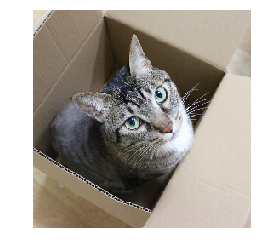

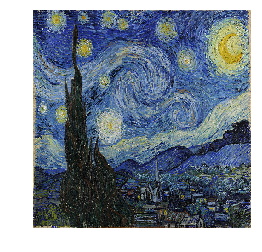

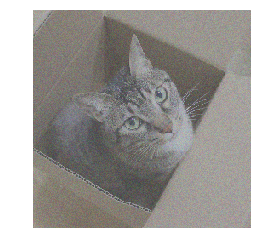

INFO:tensorflow:Restoring parameters from D:/PythonLab/CS20/models-master/research/slim/PRETRAINEDCHECKPOINTDIR/vgg_16.ckpt
step: 0  loss: 98.40099334716797  duration: 2.1950557231903076


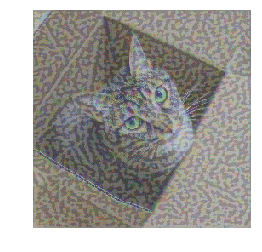

step: 100  loss: 5.042466163635254  duration: 189.67187070846558


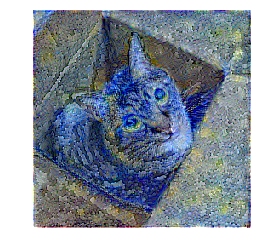

step: 200  loss: 4.550312519073486  duration: 193.08117580413818


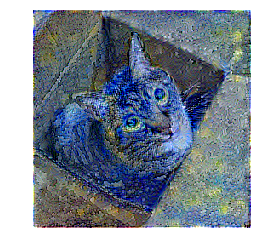

step: 300  loss: 4.422913551330566  duration: 199.03852534294128


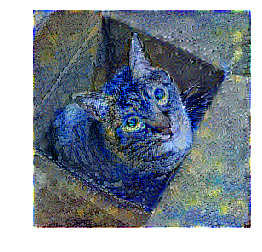

step: 400  loss: 4.361602306365967  duration: 202.34628295898438


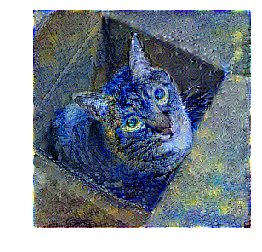

step: 500  loss: 4.352320194244385  duration: 203.61687231063843


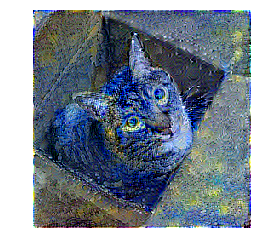

step: 600  loss: 4.310051918029785  duration: 208.11706590652466


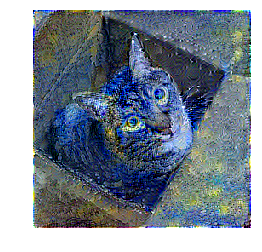

step: 700  loss: 4.303040504455566  duration: 200.53458285331726


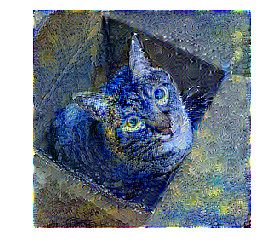

step: 800  loss: 4.306583404541016  duration: 195.32929253578186


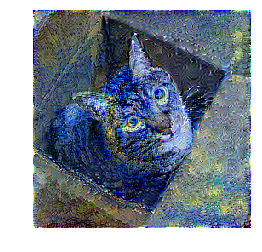

step: 900  loss: 4.274267673492432  duration: 200.6602122783661


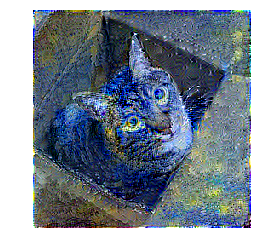

step: 1000  loss: 4.288130283355713  duration: 199.78859305381775


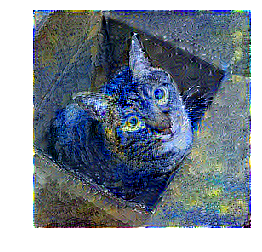

training done!


In [29]:
saver = tf.train.Saver(var_list=v)

with tf.Session(config=sess_config) as sess:
    sess.run(tf.global_variables_initializer())
    # content_image_와 style_image_를 tf.placeholder에 넣고 tf.Variable로 assign
    sess.run([content_image_op, style_image_op, generated_image_op],
           feed_dict={content_image_p: content_image_,
                      style_image_p: style_image_})

    _, generated_image_ = sess.run([generated_image_clipping, generated_image])
    print_image(content_image_)
    print_image(style_image_)
    print_image(generated_image_) # initial_image = content_image + small noise

    # use saver object to load variables from the saved model
    saver.restore(sess, checkpoint_path)
  
    start_time = time.time()
    for step in range(max_steps+1):
        _, loss_, _, generated_image_ = sess.run([train_op, total_loss, generated_image_clipping, generated_image])
        if step % print_steps == 0:
            duration = time.time() - start_time
            start_time = time.time()
            print("step: {}  loss: {}  duration: {}".format(step,
                                                          loss_,
                                                          duration))
            print_image(generated_image_)
    print('training done!')

In [35]:
def save_image(image, content_image_name, style_image_name):
    """print image

    Args:
    image: 4-rank np.array [1, h, w, 3]
    filename: name of saved image
    """
    save_image = np.squeeze(image, axis=0)
    save_image = np.clip(save_image, -1.0, 1.0)
    save_image += 1.0
    save_image /= 2.0

    save_image = Image.fromarray(np.uint8(save_image*255))
    filename = os.path.splitext(os.path.basename(content_image_name))[0] + '_'
    filename += os.path.splitext(os.path.basename(style_image_name))[0] + '.jpg'
    save_image.save(filename)

In [36]:
save_image(generated_image_, content_image_name, style_image_name)